# Salary Prediction Data : 10/10 By Apache 2.0
Kaggle Link :https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
File Name:salary_prediction_data
Columns:
1.	Education
2.	Experience
3.	Location
4.	Job Title
5.	Age
6.	Gender
7.	Salary


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import joblib
from google.colab import files

In [3]:
file_path = 'salary_prediction_data.csv'
df = pd.read_csv(file_path)
df.head()

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,High School,8,Urban,Manager,63,Male,84620.053665
1,PhD,11,Suburban,Director,59,Male,142591.255894
2,Bachelor,28,Suburban,Manager,61,Female,97800.255404
3,High School,29,Rural,Director,45,Male,96834.671282
4,PhD,25,Urban,Analyst,26,Female,132157.786175


Dataset Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null   object 
 4   Age         1000 non-null   int64  
 5   Gender      1000 non-null   object 
 6   Salary      1000 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB


Dataset Summary

In [5]:
df.describe()

,Experience,Age,Salary
count,1000.000000,1000.000000,1000.000000
mean,14.771000,42.377000,105558.404239
std,8.341111,13.609412,28256.972075
min,1.000000,20.000000,33510.510669
25%,7.000000,30.000000,85032.141517
50%,15.000000,43.000000,104314.518315
75%,22.000000,55.000000,126804.047524
max,29.000000,64.000000,193016.602150


# Data Preprocessing and Cleaning

Removing Missing value

In [6]:
print("Missing values before handling:")
print(df.isnull().sum())

df_cleaned = df.dropna()
print("\nMissing values after dropping rows:")
print(df_cleaned.isnull().sum())

Missing values before handling:
Education     0
Experience    0
Location      0
Job_Title     0
Age           0
Gender        0
Salary        0
dtype: int64

Missing values after dropping rows:
Education     0
Experience    0
Location      0
Job_Title     0
Age           0
Gender        0
Salary        0
dtype: int64


Remove Duplicate Rows

In [7]:
print("\nNumber of duplicate rows before dropping:", df_cleaned.duplicated().sum())
df_cleaned = df_cleaned.drop_duplicates()
print("Number of duplicate rows after dropping:", df_cleaned.duplicated().sum())


Number of duplicate rows before dropping: 0
Number of duplicate rows after dropping: 0


All columns have relavancy so no columns removed

Looking for Outliners

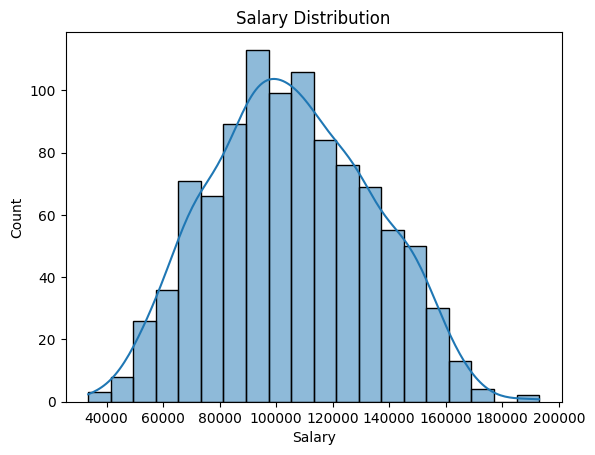

<Figure size 640x480 with 0 Axes>

In [10]:
sns.histplot(df_cleaned['Salary'], kde=True)
plt.title("Salary Distribution")
plt.show()
plt.savefig("Salary_Distribution.png", dpi=600, bbox_inches='tight')

outliners in each coloumn

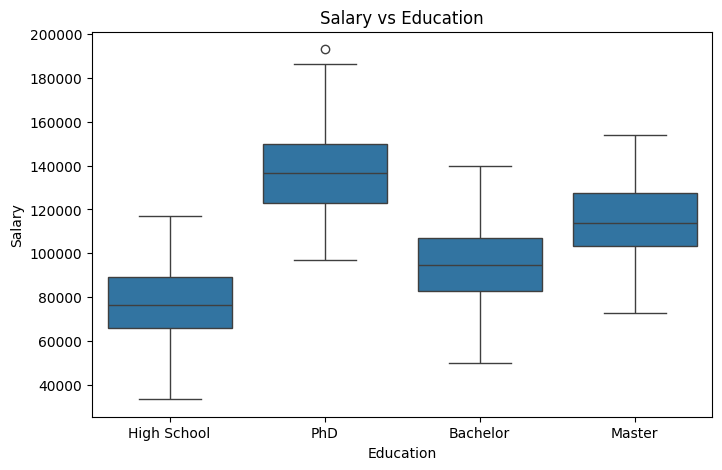

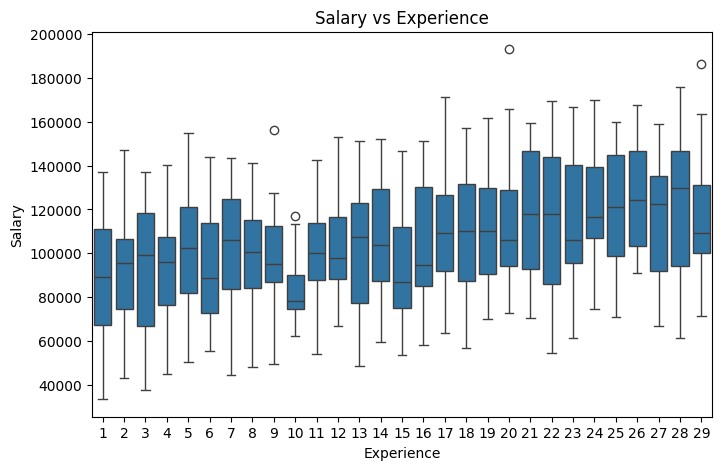

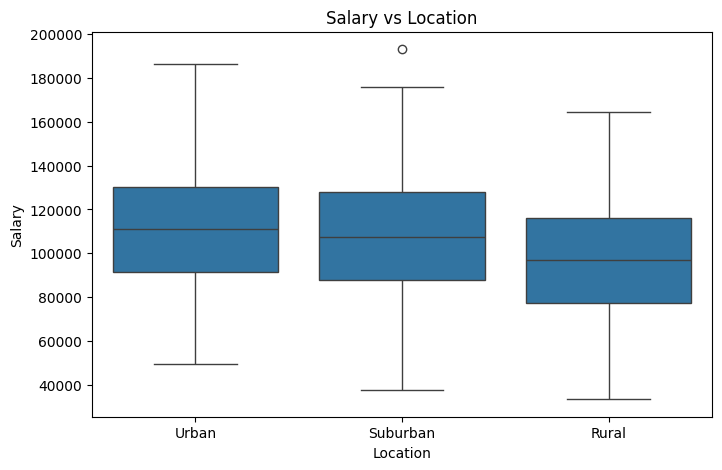

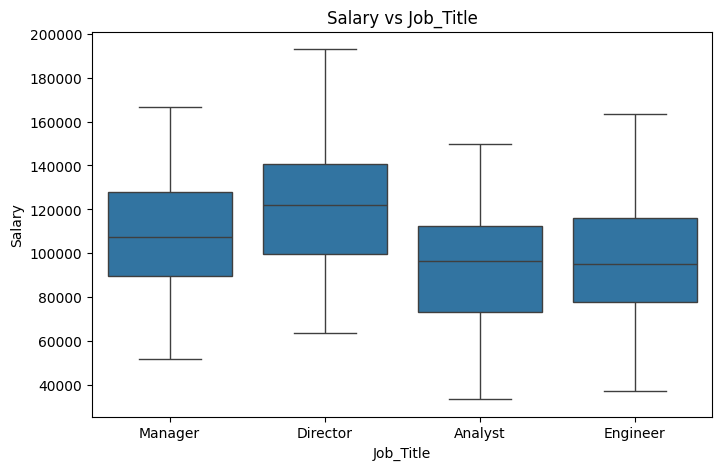

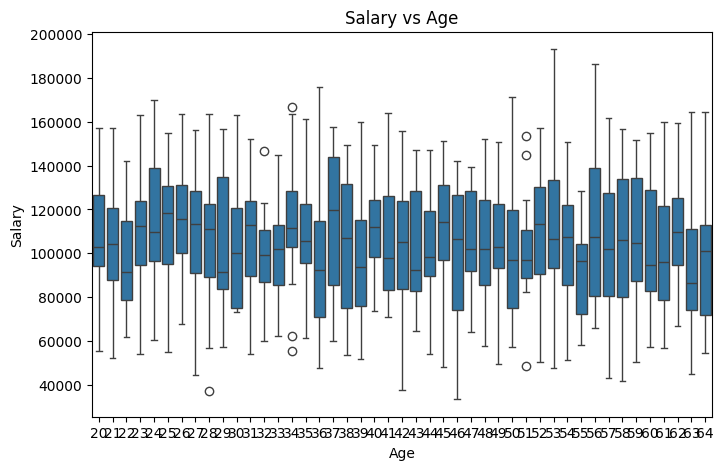

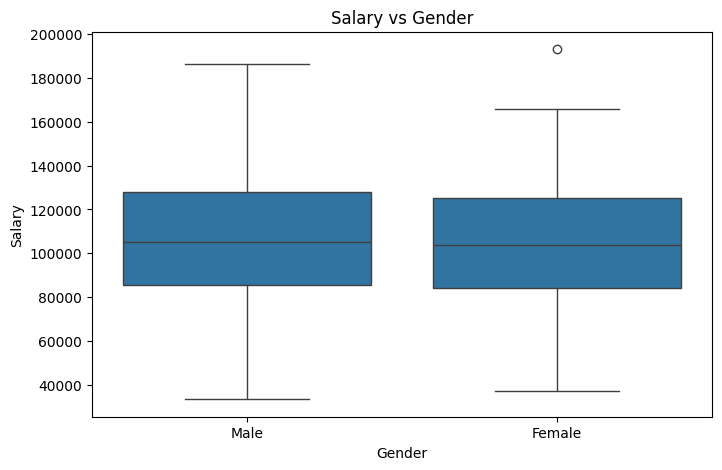

In [ ]:
for col in ['Education','Experience','Location','Job_Title','Age','Gender']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_cleaned, x=col, y="Salary")
    plt.title(f"Salary vs {col}")
    plt.show()


Shape of data before removing salary outliers: (1000, 7)
Shape of data after removing salary outliers: (999, 7)


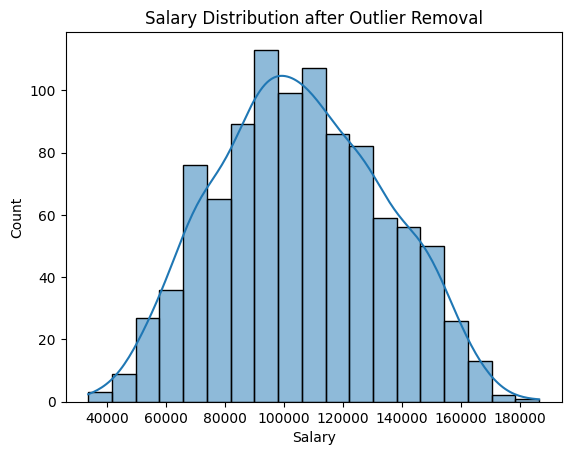

<Figure size 640x480 with 0 Axes>

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_filtered

# Identify and remove outliers from the 'Salary' column (using the cleaned DataFrame before encoding)
df_cleaned_no_outliers = remove_outliers_iqr(df_cleaned, 'Salary')

print(f"\nShape of data before removing salary outliers: {df_cleaned.shape}")
print(f"Shape of data after removing salary outliers: {df_cleaned_no_outliers.shape}")

# Visualize the distribution after outlier removal
sns.histplot(df_cleaned_no_outliers['Salary'], kde=True)
plt.title("Salary Distribution after Outlier Removal")
plt.show()
plt.savefig("outliners.png", dpi=600, bbox_inches='tight')

In [13]:
label_encoder = LabelEncoder()
for column in ['Education','Experience','Location','Job_Title','Age','Gender']:
  df_cleaned_no_outliers[column + '_encoded'] = label_encoder.fit_transform(df_cleaned_no_outliers[column])
df_encoded = df_cleaned_no_outliers.drop(columns=['Education','Experience','Location','Job_Title','Age','Gender'])
df_encoded.head()
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Salary              999 non-null    float64
 1   Education_encoded   999 non-null    int64  
 2   Experience_encoded  999 non-null    int64  
 3   Location_encoded    999 non-null    int64  
 4   Job_Title_encoded   999 non-null    int64  
 5   Age_encoded         999 non-null    int64  
 6   Gender_encoded      999 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 62.4 KB


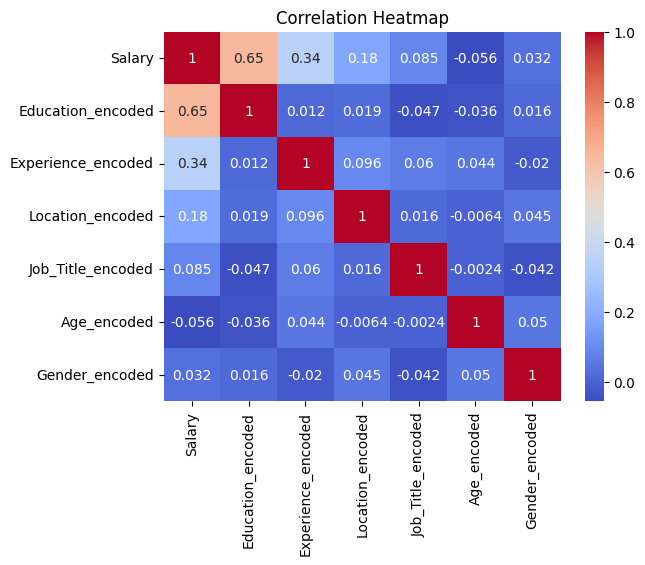

<Figure size 640x480 with 0 Axes>

In [14]:
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight')

Education and Experiance is mostly effecting the prediction

In [15]:
# Load your cleaned, outlier-free data (replace df_cleaned_no_outliers with your DataFrame)
df = df_cleaned.copy()

# Features and Target
X = df.drop('Salary', axis=1)
y = df['Salary']

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columns
categorical_cols = ['Education','Location','Job_Title','Gender']
numeric_cols = ['Age','Experience']

# Preprocessors
ridge_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

tree_preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipelines
ridge_pipeline = Pipeline([
    ('preprocess', ridge_preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

rf_pipeline = Pipeline([
    ('preprocess', tree_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocess', tree_preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42))
])

# Train Models
ridge_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Evaluate Models (Example on Test Set)
print("Ridge Test Score:", ridge_pipeline.score(X_test, y_test))
print("Random Forest Test Score:", rf_pipeline.score(X_test, y_test))
print("XGBoost Test Score:", xgb_pipeline.score(X_test, y_test))

Ridge Test Score: 0.8704012302490083
Random Forest Test Score: 0.839766115103322
XGBoost Test Score: 0.8168280319066741


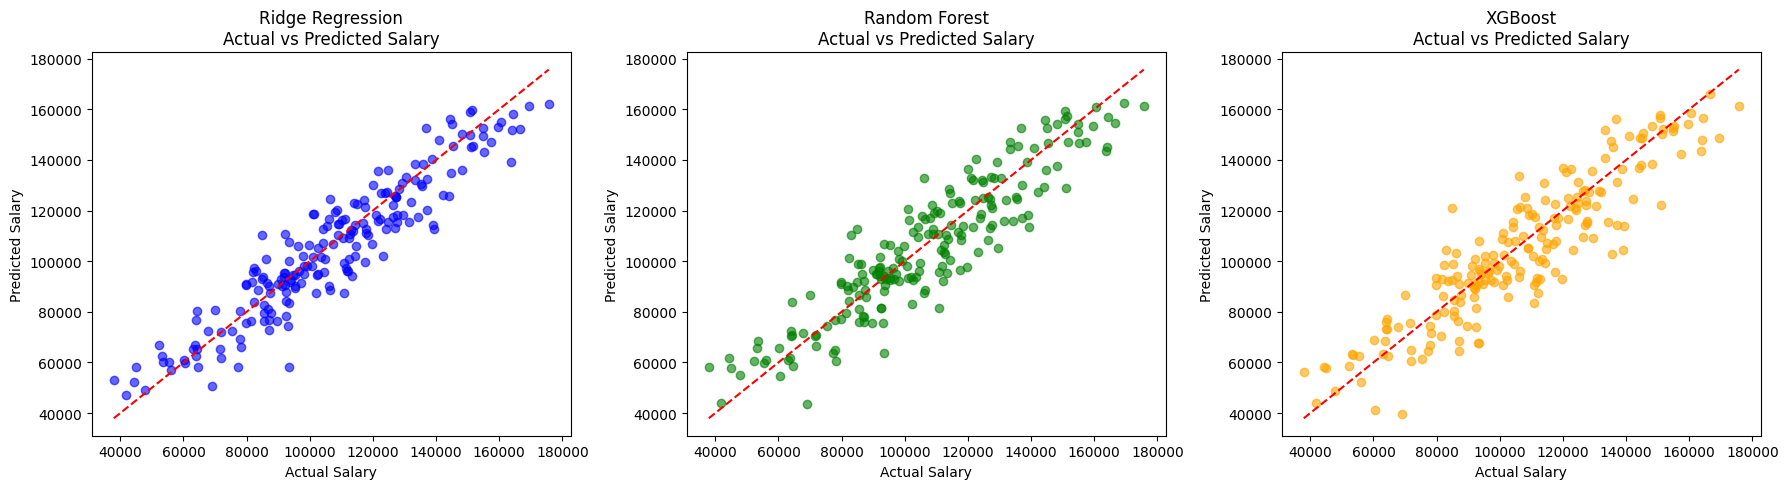

In [16]:
# Predict Salaries
ridge_pred = ridge_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)
xgb_pred = xgb_pipeline.predict(X_test)

# Plot Setup
plt.figure(figsize=(18, 5))

# Ridge Plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, ridge_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Ridge Regression\nActual vs Predicted Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

# Random Forest Plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, rf_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest\nActual vs Predicted Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

# XGBoost Plot
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost\nActual vs Predicted Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.tight_layout()
plt.show()

In [17]:
# Predictions
ridge_pred = ridge_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)
xgb_pred = xgb_pipeline.predict(X_test)

# Test Scores (R²)
ridge_r2 = r2_score(y_test, ridge_pred)
rf_r2 = r2_score(y_test, rf_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"Ridge Regression Test R² Score: {ridge_r2:.4f}")
print(f"Random Forest Test R² Score: {rf_r2:.4f}")
print(f"XGBoost Test R² Score: {xgb_r2:.4f}")

# (Optional) Mean Squared Error (MSE) for better comparison:
ridge_mse = mean_squared_error(y_test, ridge_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)

print(f"Ridge Regression Test MSE: {ridge_mse:.2f}")
print(f"Random Forest Test MSE: {rf_mse:.2f}")
print(f"XGBoost Test MSE: {xgb_mse:.2f}")

Ridge Regression Test R² Score: 0.8704
Random Forest Test R² Score: 0.8398
XGBoost Test R² Score: 0.8168
Ridge Regression Test MSE: 105820837.06
Random Forest Test MSE: 130835222.11
XGBoost Test MSE: 149564776.17


In [18]:
print("Train Scores:")
print("Ridge:", ridge_pipeline.score(X_train, y_train))
print("Random Forest:", rf_pipeline.score(X_train, y_train))
print("XGBoost:", xgb_pipeline.score(X_train, y_train))

Train Scores:
Ridge: 0.8789433945028043
Random Forest: 0.9771093969613702
XGBoost: 0.9982078243649594


In [19]:
ridge_cv = cross_val_score(ridge_pipeline, X, y, cv=5).mean()
rf_cv = cross_val_score(rf_pipeline, X, y, cv=5).mean()
xgb_cv = cross_val_score(xgb_pipeline, X, y, cv=5).mean()

print(f"Ridge CV Score: {ridge_cv:.4f}")
print(f"Random Forest CV Score: {rf_cv:.4f}")
print(f"XGBoost CV Score: {xgb_cv:.4f}")

Ridge CV Score: 0.8693
Random Forest CV Score: 0.8322
XGBoost CV Score: 0.8102


In [20]:
import joblib

# Save the pipeline (includes preprocessing + Ridge model)
joblib.dump(ridge_pipeline, "ridge_salary_model.pkl")
print("Model saved!")


Model saved!


In [ ]:
# prompt: download the model


files.download("ridge_salary_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import streamlit as st
import pandas as pd
import joblib

# Load the trained Ridge pipeline
ridge_pipeline = joblib.load("ridge_salary_model.pkl")

st.title("Salary Prediction App 💼")

st.write("Enter the details below to predict the salary:")

# Create input widgets
education = st.selectbox("Education", ["High School", "Bachelor's", "Master's", "PhD"])
experience = st.number_input("Years of Experience", min_value=0, max_value=50, step=1)
location = st.selectbox("Location", ["New York", "San Francisco", "Los Angeles", "Chicago", "Remote"])
job_title = st.selectbox("Job Title", ["Software Engineer", "Data Scientist", "Product Manager", "Designer", "Other"])
age = st.number_input("Age", min_value=18, max_value=70, step=1)
gender = st.selectbox("Gender", ["Male", "Female", "Other"])

# When the button is clicked, predict salary
if st.button("Predict Salary"):
    # Create DataFrame from inputs
    input_data = pd.DataFrame({
        'Education': [education],
        'Experience': [experience],
        'Location': [location],
        'Job_Title': [job_title],
        'Age': [age],
        'Gender': [gender]
    })

    # Predict salary
    predicted_salary = ridge_pipeline.predict(input_data)[0]

    st.success(f"Estimated Salary: ${predicted_salary:,.2f}")


In [ ]:
streamlit run app.py